In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, \
    StratifiedKFold, GridSearchCV, ParameterGrid, train_test_split, \
    cross_validate
from sklearn.metrics import accuracy_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
import time as time

# Read Data + Initial X, y Split {-}

In [2]:
df = pd.read_csv("data/heart_2020_cleaned_v2.csv")

X = df[df.columns.difference(['Unnamed: 0', 'HeartDisease'])]
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 0
)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Address Dataset Imbalance {-}

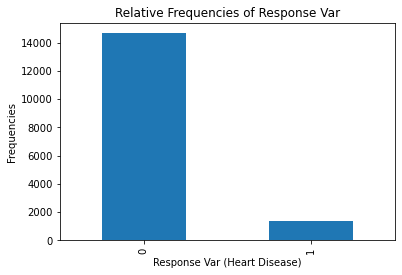

In [3]:
ax = y_train.value_counts().plot(
    kind = 'bar', title = 'Relative Frequencies of Response Var'
)
ax.set_xlabel('Response Var (Heart Disease)')
ax.set_ylabel('Frequencies')
plt.show()

In [4]:
rus = RandomUnderSampler(random_state = 1)
X_train, y_train = rus.fit_resample(X_train, y_train)

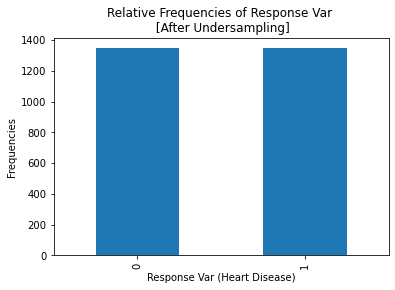

In [5]:
ax = y_train.value_counts().plot(
    kind = 'bar', 
    title = 'Relative Frequencies of Response Var \n [After Undersampling]'
)
ax.set_xlabel('Response Var (Heart Disease)')
ax.set_ylabel('Frequencies')
plt.show()

# KNearestNeighbors {-}

In [6]:
def plot_metrics_against_cutoff(model, cutoffs = np.arange(0, 1.05, 0.05)):
    accuracies = []
    recalls = []
    
    for cutoff in cutoffs:
        acc, recall = eval_model(model, cutoff)
        accuracies.append(acc)
        recalls.append(recall)
        
    plt.plot(cutoffs, accuracies, marker = 'o', label = "Accuracy")
    plt.plot(cutoffs, recalls, marker = 'o', label = "Recall")
    plt.xlabel("Cutoff")
    plt.title("Cutoffs vs. Model Performances")
    plt.legend()
    plt.grid()
    plt.show()   

def eval_model(model, cutoff = 0.5):
    y_predict = (model.predict_proba(X_test)[:,1] >= cutoff).astype(int)
    acc = accuracy_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    return acc, recall

def print_model_results(model_name, eval_results, cutoff):
    print(f"{model_name} Results [Cutoff = {cutoff}] ")
    print("Accuracy, Recall =", eval_results)

In [7]:
start = time.time()


k_range = list(range(1, 31))
grid = dict(n_neighbors=k_range)

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)
grid_search_knn = GridSearchCV(
    estimator = KNeighborsClassifier(),
    param_grid = grid,
    n_jobs = -1, 
    cv = cv,
    scoring = ['accuracy', 'recall'], 
    refit = 'recall'
).fit(X_train, y_train)

end = time.time()
print("Total Time (s):", end - start)

Total Time (s): 15.696285247802734


In [8]:
grid_search_knn.best_params_

{'n_neighbors': 7}

In [10]:
model_knn = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)

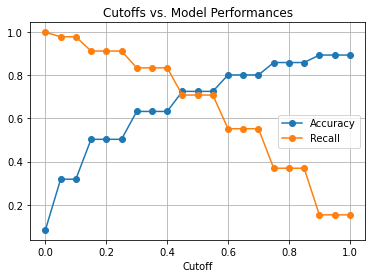

In [11]:
plot_metrics_against_cutoff(model_knn)

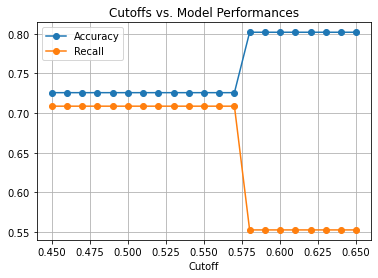

In [12]:
plot_metrics_against_cutoff(
    model_knn,
    np.arange(0.45, 0.66, 0.01)
)

In [13]:
cutoff = 0.570

print_model_results(
    "K Nearest Neighbors", 
    eval_model(model_knn, cutoff), 
    cutoff
)

K Nearest Neighbors Results [Cutoff = 0.57] 
Accuracy, Recall = (0.72575, 0.7087087087087087)


In [17]:
cutoff = 0.575

print_model_results(
    "K Nearest Neighbors", 
    eval_model(model_knn, cutoff), 
    cutoff
)

K Nearest Neighbors Results [Cutoff = 0.575] 
Accuracy, Recall = (0.802, 0.5525525525525525)


# Logistic Regression {-}

In [22]:
import warnings
warnings.filterwarnings('ignore')

start = time.time()

grid = {
    "C":np.logspace(-3,3,7), 
    "penalty":["l1","l2"],
    "solver": ['liblinear', 'saga']
}

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)
grid_search_lr = GridSearchCV(
    estimator = LogisticRegression(random_state = 1),
    param_grid = grid,
    n_jobs = -1, 
    cv = cv,
    scoring = ['accuracy', 'recall'], 
    refit = 'recall'
).fit(X_train, y_train)

end = time.time()
print("Total Time (s):", end - start)

/Users/ash/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ash/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ash/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ash/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ash/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ash/opt/anaconda3/lib/python3.9/site-packages/sklearn

Total Time (s): 8.761176824569702


In [23]:
grid_search_lr.best_params_

{'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}

In [24]:
model_lr = LogisticRegression(
     C=0.001, penalty='l2', solver='liblinear', random_state = 1
).fit(X_train, y_train)

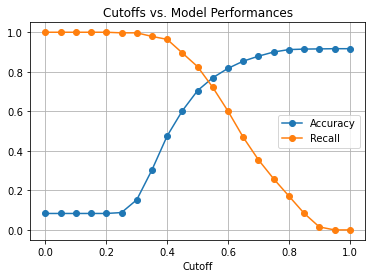

In [25]:
plot_metrics_against_cutoff(model_lr)

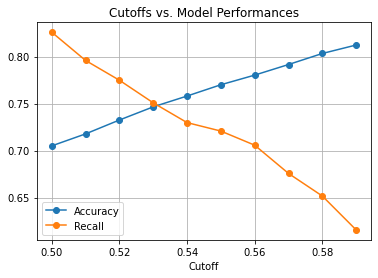

In [29]:
plot_metrics_against_cutoff(
    model_lr,
    np.arange(0.5, 0.6, 0.01)
)

In [34]:
cutoff = 0.53

print_model_results(
    "Logistic Regression", 
    eval_model(model_lr, cutoff), 
    cutoff
)

Logistic Regression Results [Cutoff = 0.53] 
Accuracy, Recall = (0.7465, 0.7507507507507507)


In [35]:
cutoff = 0.54

print_model_results(
    "Logistic Regression", 
    eval_model(model_lr, cutoff), 
    cutoff
)

Logistic Regression Results [Cutoff = 0.54] 
Accuracy, Recall = (0.758, 0.7297297297297297)


# Model Performance Comparisons {-}

# Final Model Recommendation / Performances {-}

In [ ]:
# TODO (Kind of optional - just tune cutoffs essentially?)

# Feature Importances / Takeaways {-}

In [37]:
features = list(X.columns)
coeffs_lr = model_lr.feature_importances_
coeffs_knn = model_knn.feature_importances_

df_coeffs = pd.DataFrame(
    zip(features, coeffs_lr, coeffs_knn),
    columns = [
        "Feature", "Coeffs (LR)", "Coeffs (KNN)"
    ]
)

for col in ["Coeffs (LR)", "Coeffs (KNN)"]:
    df_coeffs[col] = MinMaxScaler().fit_transform(df_coeffs[[col]])

coeff_cols = df_coeffs.iloc[:, 1:4]
df_coeffs['Avg Coeff'] = coeff_cols.mean(axis = 1)
df_coeff = df_coeffs.sort_values(by = "Avg Coeff", ascending = False)

df_coeff[['Feature', 'Avg Coeff']].iloc[:10,:]

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'